# Importing Libraries

In [31]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
import torchvision
from PIL import Image
import numpy as np
import torch.nn.functional as F
import shutil
import matplotlib.pyplot as plt
from torchcam.methods import SmoothGradCAMpp, XGradCAM

## Hyperparameters

In [32]:
seed_value= 255
torch.manual_seed(seed_value)
np.random.seed(seed_value)

path_to_data= 'C:\\Users\\ASUS\\Desktop\\IDS2\\Data\\Main_data'

IMG_SIZE = 256
targets= {0: 'io', 1:'nio'}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate=0.001
num_epochs= 100
batch_size = 128
patience = 10
counter = 0

# Preparing the data

## Loading the data

In [33]:
init_transform = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True)])

init_dataset = torchvision.datasets.ImageFolder(root=path_to_data, 
                                                transform=init_transform
                                                )
print(f"The total number of images is : {len(init_dataset)} images (from : {path_to_data})")

The total number of images is : 1973 images (from : C:\Users\ASUS\Desktop\IDS2\Data\Main_data)


## Data Augmentation

In [34]:
defect_image_transforms1 = transforms.Compose([
                                              transforms.RandomVerticalFlip(p=0.6)
                                              ])

defect_image_transforms2 = transforms.Compose([ 
                                              transforms.RandomHorizontalFlip(p=0.4) 
                                              ])

transformed_data1, transformed_data2 = [], []
for image, label in init_dataset:    
    if label == 1: 
        transformed_image1 = defect_image_transforms1(image)
        transformed_data1.append((transformed_image1, label))
        
    else: 
        # normal images
        # transformed_image2 = defect_image_transforms2(image)
        # transformed_data2.append((transformed_image2, label))
        pass
        
final_dataset = init_dataset + transformed_data1

data, labels = [], []
for image, label in final_dataset:
    data.append(image)
    labels.append(label)

print(f'After data augmentation, the total number is : {len(labels)} images, and the number of nio images is : {sum(labels)}')

After data augmentation, the total number is : 2162 images, and the number of nio images is : 378


## Splitting the data into train, validation and test sets

In [35]:
generator = torch.Generator().manual_seed(seed_value)

train_val_dataset, test_dataset = torch.utils.data.random_split(final_dataset, [0.8, 0.2], generator=generator)
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [0.8, 0.2], generator=generator)

tensor_data = torch.stack([train_val_dataset[i][0] for i in range(len(train_val_dataset))])
train_val_mean = np.mean(tensor_data.numpy())
train_val_std = np.std(tensor_data.numpy())
print(f"The number of images for train/val/test is : {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)} images")

data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(train_val_mean, train_val_std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(train_val_mean, train_val_std)
    ]),
    'pred': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.Grayscale(),
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.9, hue=0.1),
        transforms.Normalize(mean=train_val_mean, std=train_val_std)
    ])
}

The number of images for train/val/test is : 1384/346/432 images


## Creating dataloaders and applying transformations

In [36]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.data)  
    
train_data = MyDataset(train_dataset, transform=data_transforms['train'])
val_data = MyDataset(val_dataset, transform=data_transforms['train'])
test_data = MyDataset(test_dataset, transform=data_transforms['test'])

train_loader= DataLoader(train_data, batch_size=batch_size, shuffle= True, generator=generator, pin_memory = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, generator=generator, pin_memory = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=generator, pin_memory = True)



## Visualize some samples

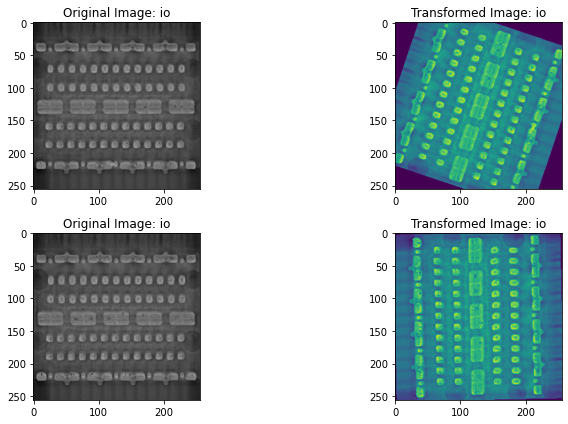

In [37]:
plt.figure(figsize= (12,6))

img1, label1 = train_dataset[1]

plt.subplot(2, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title("Original Image: {}".format(targets[label1]))

img1 = data_transforms['train'](img1)
plt.subplot(2, 2, 2)
plt.imshow(img1.permute(1, 2, 0))
plt.title("Transformed Image: {}".format(targets[label1]))

img2, label2 = test_dataset[2]

plt.subplot(2, 2, 3)
plt.imshow(img2.permute(1, 2, 0))
plt.title("Original Image: {}".format(targets[label2]))

img2 = data_transforms['test'](img2)
plt.subplot(2, 2, 4)
plt.imshow(img2.permute(1, 2, 0))
plt.title('Transformed Image: {}'.format(targets[label2]))
plt.tight_layout()

plt.show();

# Preparing the training

## Creating the model

In [38]:
class Autoencoder(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),  # Add dropout here
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Classifier(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.autoencoder = Autoencoder(dropout_rate=dropout_rate)
        with torch.no_grad():
            sample_input = next(iter(train_loader))[0]
            encoded_output = self.autoencoder.encoder(sample_input.to(device))
            flattened_size = encoded_output.view(encoded_output.size(0), -1).size(1)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(flattened_size, 2)

    def forward(self, x):
        encoded_output = self.autoencoder.encoder(x.to(device))
        encoded_output = self.dropout(encoded_output) 
        encoded_output = encoded_output.view(encoded_output.size(0), -1)
        output = self.fc(encoded_output)
        return output

In [39]:
class EarlyStopping:
    def __init__(self, patience= 5, verbose=False, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping")
        else:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)

In [40]:
model = Classifier(dropout_rate=0.5).to(device)

class_weights = torch.FloatTensor([sum(labels)/len(labels), 1 - sum(labels)/len(labels)])  # [io, nio]
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=patience, verbose=True)

## Training and Validation Loops

In [11]:
train_loss_list, val_loss_list = [], []
train_accuracy_list, val_accuracy_list = [], []
val_recall_list = []

for epoch in range(num_epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss / len(train_loader))

    val_loss, val_correct, val_total, val_tp, val_fn = 0, 0, 0, 0, 0

    y_true = np.array([])
    y_pred = np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true = np.concatenate((y_true, labels.numpy()))
            y_pred = np.concatenate((y_pred, predicted.numpy()))
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_tp += ((predicted == 1) & (labels == 1)).sum().item()
            val_fn += ((predicted == 0) & (labels == 1)).sum().item()
            
        val_accuracy = val_correct / val_total
        val_recall = val_tp / (val_tp + val_fn)
        val_accuracy_list.append(val_accuracy)
        val_loss_list.append(val_loss / len(val_loader))
        val_recall_list.append(val_recall)

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        break

    print('Epoch [{}/{}], Training Accuracy: {:.2f}%, Training Loss: {:.4f}, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
            .format(epoch + 1, num_epochs, train_accuracy * 100, train_loss, val_accuracy * 100, val_loss))

Epoch [1/100], Training Accuracy: 54.68%, Training Loss: 37.8879, Validation Accuracy: 18.79%, Validation Loss: 2.1364
Epoch [2/100], Training Accuracy: 18.01%, Training Loss: 8.1465, Validation Accuracy: 57.80%, Validation Loss: 2.0779
Epoch [3/100], Training Accuracy: 42.51%, Training Loss: 7.5854, Validation Accuracy: 81.21%, Validation Loss: 2.0812
Epoch [4/100], Training Accuracy: 77.52%, Training Loss: 7.5967, Validation Accuracy: 80.92%, Validation Loss: 2.0798
Epoch [5/100], Training Accuracy: 63.11%, Training Loss: 7.5202, Validation Accuracy: 81.21%, Validation Loss: 2.0738
Epoch [6/100], Training Accuracy: 63.26%, Training Loss: 7.4068, Validation Accuracy: 76.30%, Validation Loss: 2.0283
Epoch [7/100], Training Accuracy: 60.37%, Training Loss: 7.0650, Validation Accuracy: 84.68%, Validation Loss: 1.9855
Epoch [8/100], Training Accuracy: 68.44%, Training Loss: 6.3127, Validation Accuracy: 89.31%, Validation Loss: 1.7137
Epoch [9/100], Training Accuracy: 81.20%, Training Loss

## Plot training and validation loss/accuracy

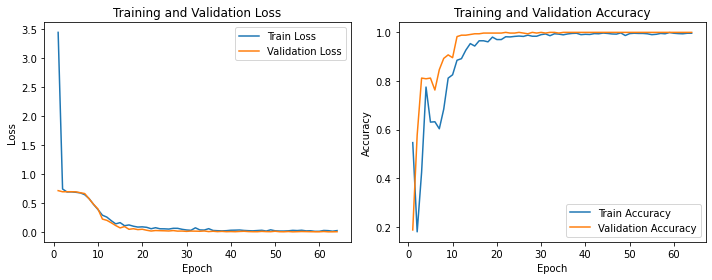

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

x = range(1, len(train_loss_list) + 1)
axes[0].plot(x, train_loss_list, label='Train Loss')
axes[0].plot(x, val_loss_list, label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(x, train_accuracy_list, label='Train Accuracy')
axes[1].plot(x, val_accuracy_list, label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

## Validation performance  (Confusion Matrix, Recall, F1 score)

In [13]:
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['io', 'nio'])
recall= recall_score( y_true, y_pred, average='binary')
f1= f1_score( y_true, y_pred, average='binary')

print('\n', 'Confusion Matrix:\n', cm)
print('\n', 'Classification Report:\n', report)
print('\n', "Recall is equal to: ", round(recall,3))
print('\n', "f1_score is equal to: ", round(f1,3))


 Confusion Matrix:
 [[281   0]
 [  0  65]]

 Classification Report:
               precision    recall  f1-score   support

          io       1.00      1.00      1.00       281
         nio       1.00      1.00      1.00        65

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346


 Recall is equal to:  1.0

 f1_score is equal to:  1.0


# Save the final model checkpoint

In [14]:
torch.save(model.state_dict(), 'model.pt')

## Load the model checkpoint

In [41]:
model = Classifier().to(device)
model.load_state_dict(torch.load('model.pt'))
model.eval();

## Testing the model on test data

In [42]:
model.eval()
y_true = []
y_pred = []
test_loss = 0
test_correct = 0
test_total = 0
test_tp = 0 
test_fn = 0 

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_tp += ((predicted == 1) & (labels == 1)).sum().item()
        test_fn += ((predicted == 0) & (labels == 1)).sum().item()
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

test_accuracy = test_correct / test_total
test_recall = test_tp / (test_tp + test_fn)
test_f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print('Test Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Recall: {:.2f}%, Test f1: {:.2f}%'
          .format(test_accuracy * 100, test_loss / len(test_loader), test_recall * 100, test_f1 * 100))
print('\n', 'Confusion Matrix:')
print('\n', cm)
print('\n', 'Classification Report:')
print('\n', report)


Test Accuracy: 100.00%, Test Loss: 0.0036, Test Recall: 100.00%, Test f1: 100.00%

 Confusion Matrix:

 [[364   0]
 [  0  68]]

 Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       364
           1       1.00      1.00      1.00        68

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



# Prediction to new Images

## For a Folder of images

In [43]:
io_dir = 'C:\\Users\\ASUS\\Data\\Prediction\\Predictedimages\\io'
nio_dir = 'C:\\Users\\ASUS\\Data\\Prediction\\Predictedimages\\nio'
os.makedirs(io_dir, exist_ok=True)
os.makedirs(nio_dir, exist_ok=True)

folder_path= 'C:\\Users\\ASUS\\Data\\Prediction\\Data'

for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)

    image = Image.open(image_path).convert('RGB')
    image = data_transforms['pred'](image)
    image = image.unsqueeze(0) 

    with torch.no_grad():
        output = model(image)

    _, predicted_idx = torch.max(output, 1)

    predicted_label = "io" if predicted_idx.item() == 0 else "nio"

    if predicted_label == 'io':
        shutil.copy2(image_path, io_dir)
    else:
        shutil.copy2(image_path, nio_dir)
    print(f"Image: {filename}, Predicted label: {predicted_label}")


Image: iO_1019.jpg, Predicted label: io
Image: iO_1187.jpg, Predicted label: io
Image: iO_1451.jpg, Predicted label: io
Image: iO_15.jpg, Predicted label: io
Image: iO_1727.jpg, Predicted label: io
Image: iO_1794.jpg, Predicted label: io
Image: iO_22.jpg, Predicted label: io
Image: iO_220.jpg, Predicted label: io
Image: iO_25.jpg, Predicted label: io
Image: iO_4.jpg, Predicted label: io
Image: iO_427.jpg, Predicted label: io
Image: iO_53.jpg, Predicted label: io
Image: iO_683.jpg, Predicted label: io
Image: iO_76.jpg, Predicted label: io
Image: iO_863.jpg, Predicted label: io
Image: niO_145.jpg, Predicted label: nio
Image: niO_15.jpg, Predicted label: nio
Image: niO_167.jpg, Predicted label: nio
Image: niO_189.jpg, Predicted label: nio
Image: niO_27.jpg, Predicted label: nio
Image: niO_39.jpg, Predicted label: nio
Image: niO_45.jpg, Predicted label: nio
Image: niO_53.jpg, Predicted label: nio
Image: niO_69.jpg, Predicted label: nio
Image: niO_89.jpg, Predicted label: nio
Image: niO_92.

## For a specific image

In [47]:

image_path= 'C:\\Users\\ASUS\\Data\\io_1748.jpg'

image = Image.open(image_path).convert('RGB')
image = data_transforms['pred'](image)
image = image.unsqueeze(0) 

with torch.no_grad():
    output = model(image)

_, predicted_idx = torch.max(output, 1)
predicted_label = "io" if predicted_idx.item() == 0 else "nio"

print("Predicted label:", predicted_label)

Predicted label: io


# Classifying the defect images on different groups

## Visualize feature maps

In [48]:

from PIL import Image

image_path= 'C:\\Users\\ASUS\\Desktop\\Data\\nio_53.jpg'

sample_image = Image.open(image_path).convert('RGB')
org_size = sample_image.size
sample_image = data_transforms['pred'](sample_image)

# Use dataloader
# sample_image = next(iter(train_loader))[0][0]
# print(sample_image.shape)
print(org_size, "->", sample_image.shape)


(623, 483) -> torch.Size([1, 256, 256])


### Visualization of ALL Feature Maps

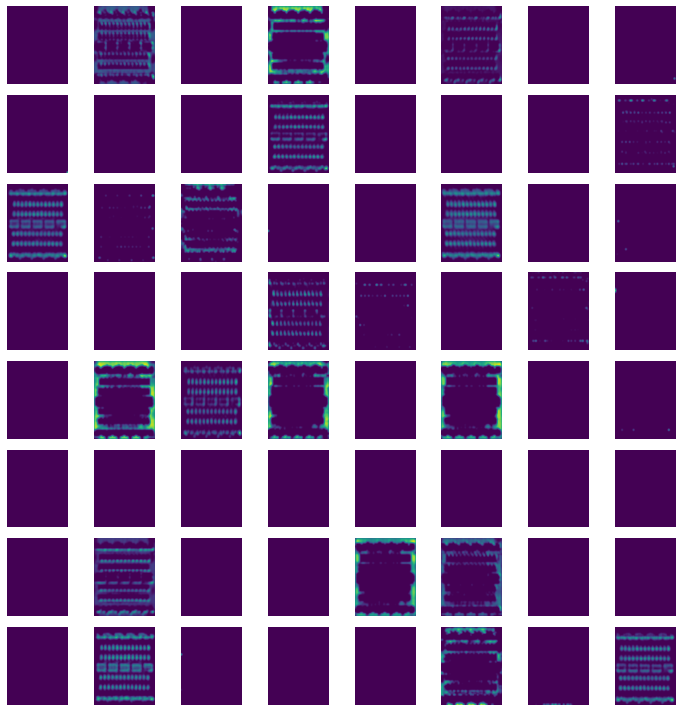

In [49]:
def visualize_all_feature_maps(model, image, onlyLastConv=False):
    model.eval()
    feature_maps = []
    x = image
    for layer in model.autoencoder.encoder:
        x = layer(x)

        if isinstance(layer, nn.Conv2d):
            feature_maps.append((layer._get_name(), x))

    if onlyLastConv: feature_maps = feature_maps[-1:]

    
    plt.figure(figsize=(10, 10))
    for i, (name, feature_map) in enumerate(feature_maps):
        num_features = feature_map.size(0)
        rows = int(num_features**0.5)
        cols = (num_features + rows - 1) // rows

        for j in range(num_features):
            plt.subplot(rows, cols, j + 1)
            feature = feature_map[j].cpu()

            if (feature.shape != image.shape[1:]):
                feature = F.interpolate(feature.unsqueeze(0).unsqueeze(0),
                                        size=org_size,
                                        mode='bilinear',
                                        align_corners=False
                                        ).squeeze()

            plt.axis('off')

            plt.imshow(feature.detach().numpy(), cmap='viridis', interpolation="bicubic")

        if not onlyLastConv:
             plt.suptitle(f"Encoder Layer {i+1} ({name})")
        plt.tight_layout()
        plt.show()
        
visualize_all_feature_maps(model, sample_image, onlyLastConv=True)

### Gradient-based methods

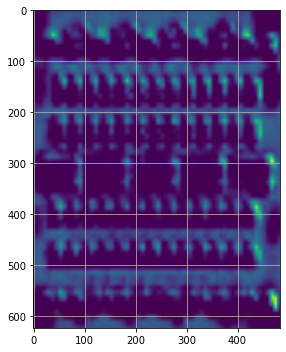

In [52]:
def visualize_SmoothGradCampp(model, image, std, size, onlyLastConv=False):
    model.eval()
    plt.figure(figsize=(10, 5))

    layers = [layer for layer in model.autoencoder.encoder if isinstance(layer, nn.Conv2d)]
    if onlyLastConv: 
        layers = [layers[-1]]

    for i, layer in enumerate(layers):
        cam = SmoothGradCAMpp(
                                model.autoencoder.encoder,
                                target_layer=layer,
                                num_samples=50,
                                std=std
                            )
        scores = model.autoencoder.encoder(image.unsqueeze(0))
        activation_map = cam(class_idx=1, scores=scores)[0]
        while activation_map.dim() != 4:
            activation_map = activation_map.unsqueeze(0) 

        activation_map = F.interpolate( activation_map,
                                        size=size,
                                        mode='bilinear',
                                        align_corners=True
                                        )
        while activation_map.dim() > 2:
            activation_map = activation_map.squeeze(0)

        plt.imshow(activation_map, cmap='viridis', interpolation="bicubic")
        if not onlyLastConv:
            plt.suptitle(f"Layer {i+1} ({layer._get_name()})")

        plt.tight_layout()
        plt.grid(True)
        plt.savefig(f'heatmap{i+1}.png')
        plt.show()

visualize_SmoothGradCampp(model, sample_image, std=train_val_std, size=org_size, onlyLastConv=True)

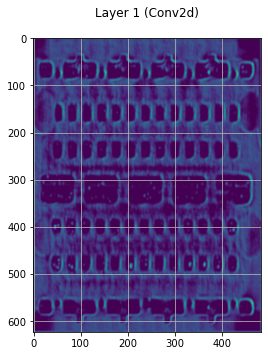

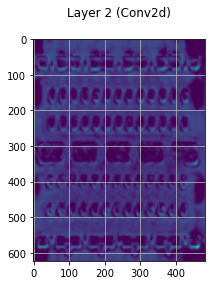

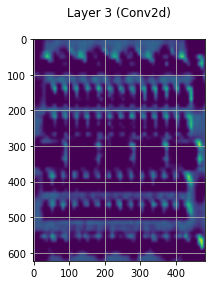

In [54]:
def visualize_XGradCAM(model, image, size, onlyLastConv=False):
    model.eval()
    plt.figure(figsize=(10, 5))
    layers = [layer for layer in model.autoencoder.encoder if isinstance(layer, nn.Conv2d)]
    
    if onlyLastConv:
        layers = [layers[-1]]

    for i, layer in enumerate(layers):
        cam = XGradCAM(model.autoencoder.encoder, target_layer=layer)
        scores = model.autoencoder.encoder(image.unsqueeze(0))
        activation_map = cam(class_idx=1, scores=scores)[0]
        while activation_map.dim() != 4:
            activation_map = activation_map.unsqueeze(0) 
        
        activation_map = F.interpolate(activation_map,
                                        size=size,
                                        mode='bilinear',
                                        align_corners=True
                                        )

        while activation_map.dim() > 2:
            activation_map = activation_map.squeeze(0)
        plt.imshow(activation_map, cmap='viridis',  interpolation="bicubic")
        
        if not onlyLastConv:
            plt.suptitle(f"Layer {i+1} ({layer._get_name()})")

        plt.tight_layout()
        plt.grid(True)

        plt.savefig(f'heatmap{i+1}.png')
        plt.show()
visualize_XGradCAM(model, sample_image, size=org_size, onlyLastConv=False)